In [37]:
%autoreload 2
from datetime import datetime
import os
import re
import numpy as np
import pandas as pd
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# let's pollute the namespace
from jp_utils.constants.earth import *
from jp_utils.general import *
from jp_utils.orbit_utils import *

In [38]:
# config
EPHEM_PATH   = 'j2_only.ffephem'
DURATION = 39800 # seconds
EPHEM_STEP = 10  # seconds
CURTIS_INIT_STATE = [ -2384.46, 5729.01, 3050.46, -7.36138, -2.98997, 1.64354 ]
FF_INIT_STATE = [ 8000, 0, 0, 0, 5.7462, 5.1739]
INIT_STATE = FF_INIT_STATE

# read in and parse the ephem
ephem = []
with open(EPHEM_PATH, 'r') as eph_input:
    for skip_header in range(2):
        next(eph_input)
    for line in eph_input:
        line = line.strip()
        (epoch, x, y, z, vx, vy, vz) = re.compile("\s{2,100}").split(line)
        ephem.append(np.array([
            float(x), float(y), float(z),
            float(vx), float(vy), float(vz),
        ]))

In [39]:
def perturbed(t, state):
    state_update = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    state_update += accel_point_mass(t, state)
    state_update += accel_j2(t, state)
    return state_update

result = solve_ivp(
    perturbed, # function to solve
    (0, DURATION), # start/stop
    INIT_STATE, # intitial state
    t_eval=range(0, DURATION, EPHEM_STEP), # times to evaluate at
    rtol=1e-11, # relative tolerance
)
orbit_solution = result.y
t = result.t

initial_state   = orbit_solution[:,0]
initial_energy  = calc_energy(initial_state)
initial_h_mag   = np.sum(calc_h(initial_state)**2)**0.5
initial_h       = calc_h(initial_state)
initial_ecc_vec = calc_ecc(initial_state)

print('my energy loss', calc_energy(orbit_solution[:,-1]) - initial_energy)
print('ff energy loss', calc_energy(ephem[-1]) - calc_energy(ephem[0]))

my energy loss -6.48440923960436e-05
ff energy loss -9.153804097650209e-05


In [40]:
# plot data
energy = []
ff_energy = []

data = {
    'sma': [], 'inc': [], 'ecc': [],
    'aop': [], 'ran': [], 'tam': [],
}

kep_derivative = {
    'sma': [], 'inc': [], 'ecc': [],
    'aop': [], 'ran': [], 'tam': [],
}

for i in range(len(orbit_solution[0])):
    energy.append( calc_energy(orbit_solution[:,i]) - initial_energy )
    ff_energy.append( calc_energy(ephem[i]) - calc_energy(ephem[0]))
    
    kep = cartesian_to_keplerian(orbit_solution[:,i])
    for field in ['sma', 'ecc', 'inc', 'ran', 'aop', 'tam']:
        data[field].append(kep[field])
    
    if i > 1:
        for field in ['sma', 'ecc', 'inc', 'ran', 'aop', 'tam']:
            kep_derivative[field].append((data[field][i] - data[field][i-2])/2)

df = pd.DataFrame(kep_derivative)

3978
3978


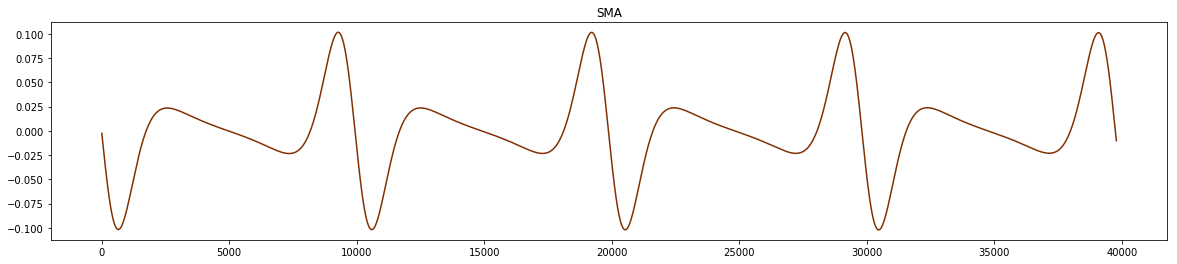

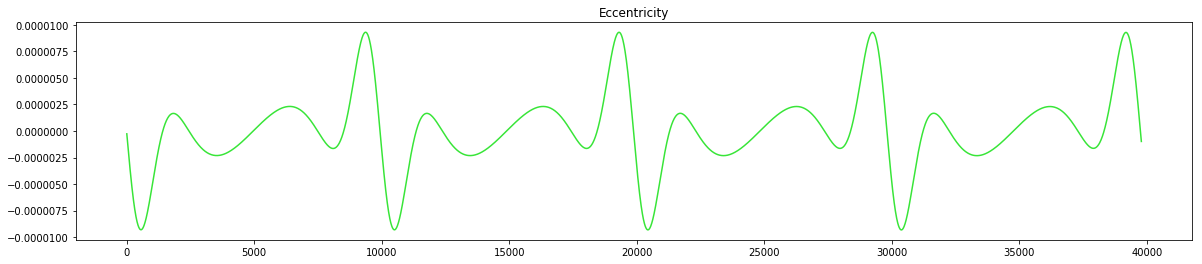

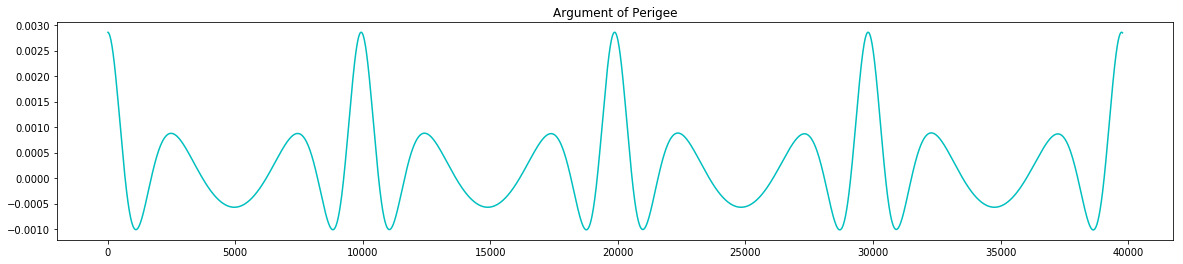

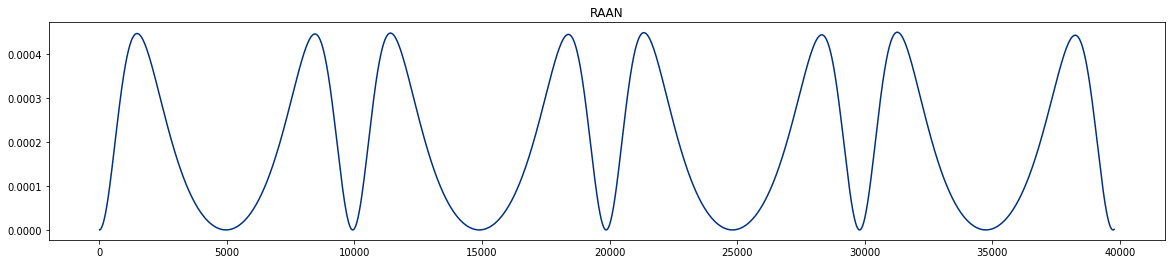

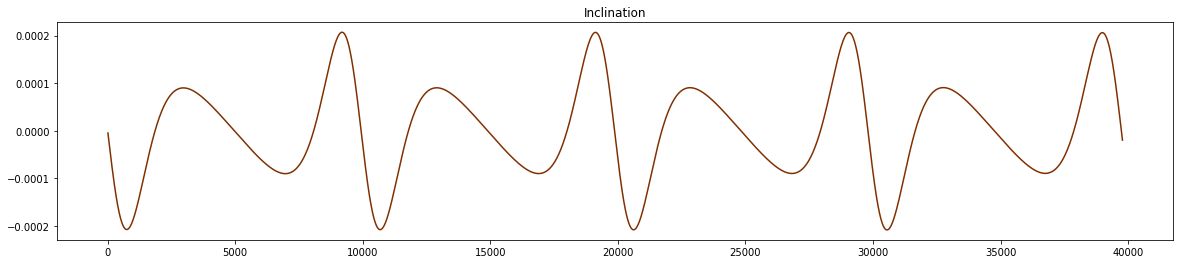

In [41]:
PLOT_FIGSIZE = (20, 4)
data = kep_derivative
tmp = t
t = tmp[1:-1]
print(len(t))
print(len(data['inc']))
def plot(title, t, data, color):
    plt.figure(figsize=PLOT_FIGSIZE)
    plt.title(title)
    plt.plot(t, data, color)
    plt.show()
plot('SMA', t, data['sma'], '#803000')
plot('Eccentricity', t, data['ecc'], '#38e538')
plot('Argument of Perigee', t, np.degrees(data['aop']), 'c')
plot('RAAN', t, np.degrees(data['ran']), '#003080')
plot('Inclination', t, np.degrees(data['inc']), '#803000')

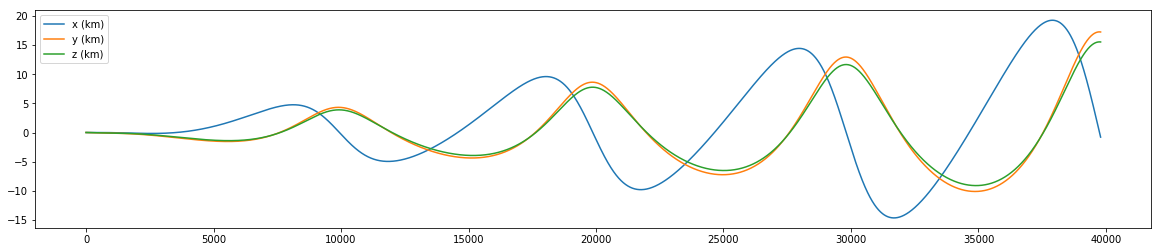

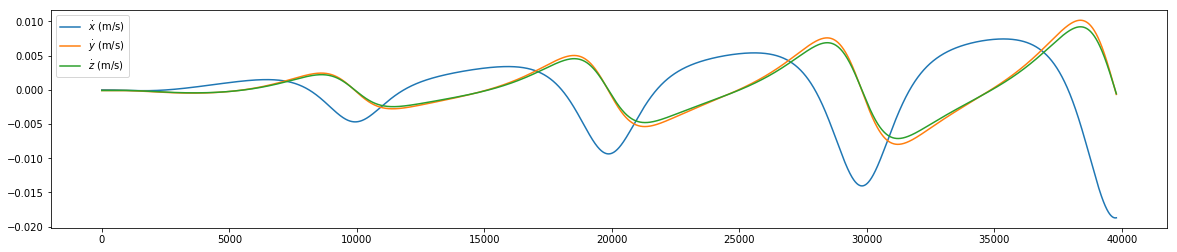

In [42]:
diffs = []
epochs = []
for i in range(len(orbit_solution[0])):
    epochs.append(i*EPHEM_STEP)
    diffs.append(orbit_solution[:,i] - ephem[i])
    
diffs = np.array(diffs)

plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(epochs, diffs[:,0:3])
plt.legend(['x (km)', 'y (km)', 'z (km)'])
plt.show()

plt.figure(figsize=PLOT_FIGSIZE)
plt.plot(epochs, diffs[:,3:6])
plt.legend(['$\dot{x}$ (m/s)', '$\dot{y}$ (m/s)', '$\dot{z}$ (m/s)'])
plt.show()